Efficient Frontier according to the Markowitz Model.
This policy requires us to be very accurate at predicting prices in advance.
Due to the changing prices, the efficient frontier is dynamic in nature, resulting in dynamic weights for different assets.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
sns.set_style('whitegrid')

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
start_date = "2011-01-01"
end_date = "2018-01-01"

In [ ]:
ticker = "^TNX"
data = yf.download(ticker, start=start_date, end=end_date)
risk_free_rate = data['Adj Close'].iloc[-1]/(100*252)
print("Risk-Free Rate (10-year Treasury Yield):", risk_free_rate)

[*********************100%%**********************]  1 of 1 completed

Risk-Free Rate (10-year Treasury Yield): 9.543650680118137e-05


In [ ]:
tickers = ['AAPL', 'LH', 'SLB', 'V']
N_tickers = len(tickers)
data = yf.download(tickers, start=start_date, end=end_date)
ticker_df = pd.DataFrame(data['Adj Close'])
ticker_df = ticker_df.shift(-1) / ticker_df - 1
ticker_df = ticker_df.dropna()

[*********************100%%**********************]  4 of 4 completed


In [ ]:
total_len = len(ticker_df)
train_len = int(total_len * 0.8)
test_len = total_len - train_len

In [ ]:
def get_return_risk(weights):
  #portfolio_returns = ticker_df.dot(weights) - risk_free_df['returns']
  portfolio_returns = ticker_df.dot(weights)
  mean = portfolio_returns.mean()
  risk = portfolio_returns.std()
  return mean, risk

In [ ]:
N_samples = 10000
samples = np.zeros((N_samples, 2))
weights = np.zeros((N_samples, N_tickers))

for i in range(N_samples):
  w = np.random.random(N_tickers)
  w /= np.sum(w)
  mean, std = get_return_risk(w)
  samples[i, 0] = mean
  samples[i, 1] = std
  weights[i, :] = w

In [ ]:
highest_return = np.argmax(samples[:, 0])
y1, x1 = samples[highest_return]
lowest_risk = np.argmin(samples[:, 1])
y2, x2 = samples[lowest_risk]
highest_sharpe_ratio = np.argmax(samples[:, 0] / samples[:, 1])
y3, x3 = risk_free_rate, 0

In [ ]:
highest_return_weights = weights[highest_return]
lowest_risk_weights = weights[lowest_risk]
highest_sharpe_ratio_weights = weights[highest_sharpe_ratio]

In [ ]:
sharpe_ratios = samples[:, 0] / samples[:, 1]
risks = samples[:, 1]
returns = samples[:, 0]

# Identify the tangency portfolio (max Sharpe Ratio)
max_sharpe_idx = np.argmax(sharpe_ratios)
market_return = returns[max_sharpe_idx]
market_risk = risks[max_sharpe_idx]

# Define the CML function
def cml(x, market_return, market_risk):
    return ((market_return - risk_free_rate)/market_risk) * x + risk_free_rate

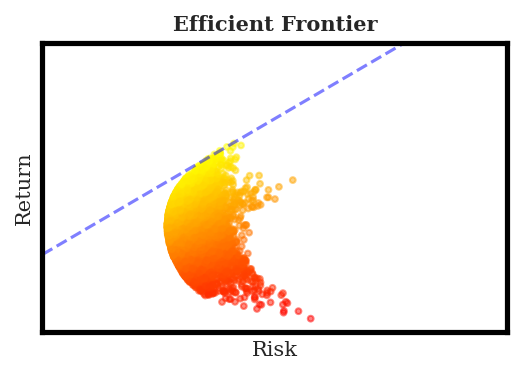

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5), dpi=150)

ax.scatter(samples[:, 1], samples[:, 0], s=7.5, cmap='autumn', c=samples[:, 0] / samples[:, 1], alpha=0.5)


ax.grid(False)

ax.set_xlabel('Risk', fontsize=10, fontfamily='serif')
ax.set_ylabel('Return', fontsize=10, fontfamily='serif')

x_lim = [samples[:, 1].min() * 0.5, samples[:, 1].max() * 1.5]
y_lim = [samples[:, 0].min() * 0.5, samples[:, 0].max() * 1.5]

xs = np.linspace(x_lim[0], x_lim[1], 100)
ys = cml(xs, market_return, market_risk)

ax.plot(xs, ys, linestyle='--', color='b', lw=1.5, alpha=0.5)

ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

ax.set_xticks([])
ax.set_yticks([])

for splines in ax.spines.values():
  splines.set_linewidth(2.5)
  splines.set_color('k')

ax.set_title('Efficient Frontier', fontsize=10, fontfamily='serif', fontweight='bold')


plt.show()

In [ ]:
def portfolio_value_history(initial_budget, weights):
  value_history = np.zeros(len(ticker_df))
  value_history[0] = initial_budget
  for i in range(1, len(ticker_df)):
    r = ticker_df.iloc[i].dot(weights)
    value_history[i] = value_history[i-1] *(r+1)
  return value_history

In [ ]:
seq = ticker_df
def objective(weights):
  return -np.mean(seq.dot(weights))/np.std(seq.dot(weights))
def constraint(weights):
  return np.sum(weights) - 1
def best_weights(seq):
  constraints = {
      'type': 'eq',
      'fun': constraint
  }
  bounds = [(0, 1.0) for _ in range(len(seq.columns))]
  result = minimize(objective, np.ones(len(seq.columns)) / len(seq.columns), method='SLSQP', bounds=bounds, constraints=constraints)
  return result.x

In [ ]:
weights_1 = best_weights(seq)

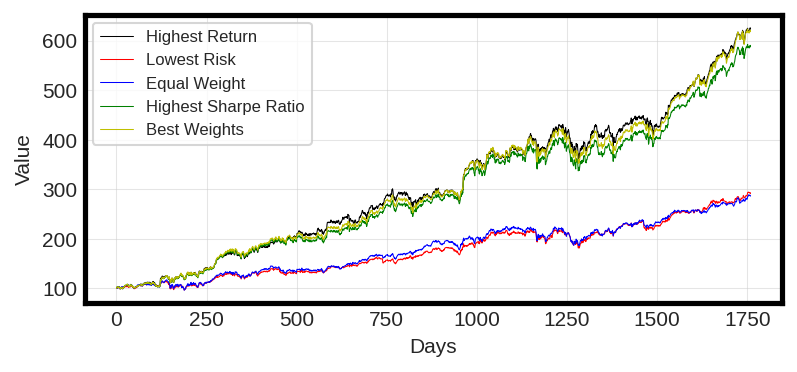

In [ ]:
history_1 = portfolio_value_history(100, highest_return_weights)
history_2 = portfolio_value_history(100, lowest_risk_weights)
history_3 = portfolio_value_history(100, np.ones(N_tickers) / N_tickers)
history_4 = portfolio_value_history(100, highest_sharpe_ratio_weights)
history_5 = portfolio_value_history(100, weights_1)

fig, ax = plt.subplots(1, 1, figsize=(6, 2.5), dpi=150)

ax.plot(history_1, linestyle='-', color='k', lw=0.5, label = 'Highest Return')
ax.plot(history_2, linestyle='-', color='r', lw=0.5, label = 'Lowest Risk')
ax.plot(history_3, linestyle='-', color='b', lw=0.5, label = 'Equal Weight')
ax.plot(history_4, linestyle='-', color='g', lw=0.5, label = 'Highest Sharpe Ratio')
ax.plot(history_5, linestyle='-', color='y', lw=0.5, label = 'Best Weights')

ax.set_xlabel('Days')
ax.set_ylabel('Value')

ax.legend(fontsize=8, frameon=True)

ax.grid(True, lw=0.5, alpha=0.5)

for splines in ax.spines.values():
  splines.set_linewidth(2.5)
  splines.set_color('k')

plt.show()

In [ ]:
class Optimal_Strategy:

  def __init__(self, ticker_df, trading_window=75):
    self.ticker_df = ticker_df
    self.trading_window = trading_window
    self.best_weights_history = None

  def get_return_risk(self, weights, seq):
    portfolio_returns = seq.dot(weights)
    mean = portfolio_returns.mean()
    risk = portfolio_returns.std()
    return mean, risk

  def sharpe_ratio(self, seq, weights):
    return np.mean(seq.dot(weights))/np.std(seq.dot(weights))

  def get_best_weights(self, seq):
    N_samples = 5000
    weights = np.zeros((N_samples, len(seq.columns)))
    sp_ratios = np.zeros(N_samples)
    for i in range(N_samples):
      w = np.random.random(len(seq.columns))
      w /= np.sum(w)
      sp_ratios[i] = self.sharpe_ratio(seq, w)
      weights[i, :] = w
    highest_sharpe_ratio = np.argmax(sp_ratios)
    return weights[highest_sharpe_ratio]

  def update_best_weights(self):
    best_weights_history = np.zeros((len(self.ticker_df) - self.trading_window, len(self.ticker_df.columns)))
    for i in range(self.trading_window, len(self.ticker_df)):
      seq = self.ticker_df.iloc[i-self.trading_window:i]
      best_weights_history[i-self.trading_window] = self.get_best_weights(seq)
    self.best_weights_history = best_weights_history

  def price_history(self, initial_budget):
    price_history = np.zeros((len(self.ticker_df) - self.trading_window, len(self.ticker_df.columns)))
    price_history[0] = initial_budget
    for i in range(1, len(price_history)):
      price_history[i] = price_history[i-1] * (1 + self.ticker_df.iloc[i+self.trading_window-1].dot(self.best_weights_history[i-1]))
    return price_history

In [ ]:
OS=Optimal_Strategy(ticker_df)
OS.update_best_weights()

In [ ]:
price_history = np.zeros((len(ticker_df) - OS.trading_window, len(ticker_df.columns)))
price_history[0] = 100
for i in range(1, len(price_history)):
  price_history[i] = price_history[i-1] * (1 + ticker_df.iloc[i+OS.trading_window-1].dot(OS.best_weights_history[i-1]))
equal_weights_price_history = np.zeros_like(price_history)
equal_weights_price_history[0] = 100
for i in range(1, len(equal_weights_price_history)):
  equal_weights_price_history[i] = equal_weights_price_history[i-1] * (1 + ticker_df.iloc[i+OS.trading_window-1].mean())

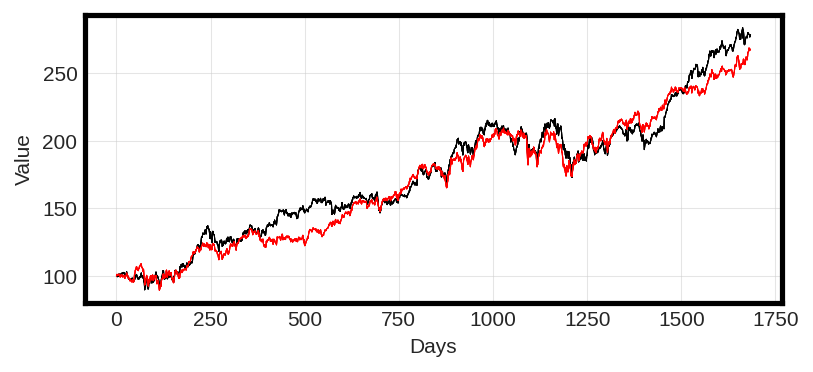

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5), dpi=150)

ax.plot(price_history, linestyle='-', color='k', lw=0.5)
ax.plot(equal_weights_price_history, linestyle='-', color='r', lw=0.5)

ax.set_xlabel('Days')
ax.set_ylabel('Value')

ax.grid(True, lw=0.5, alpha=0.5)

for splines in ax.spines.values():
  splines.set_linewidth(2.5)
  splines.set_color('k')

plt.show()

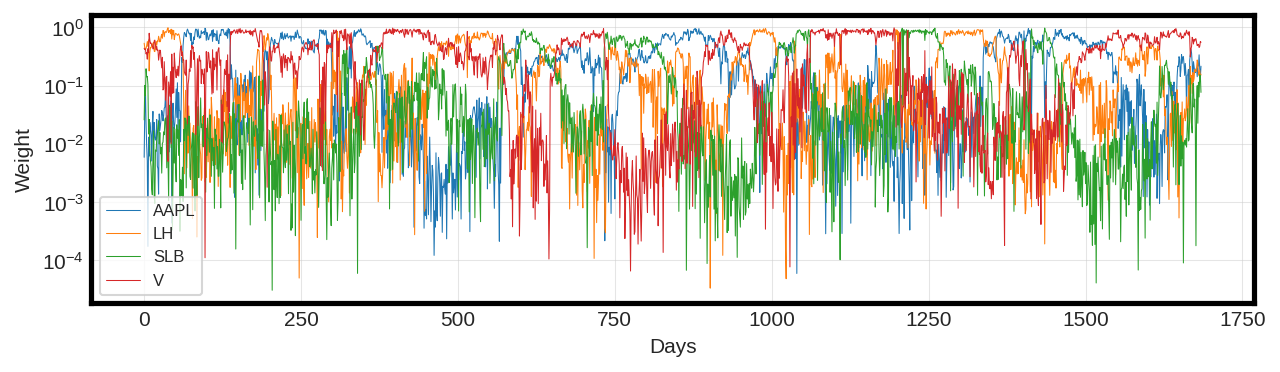

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2.5), dpi=150)

for i in range(len(OS.best_weights_history[0])):
  ax.semilogy(OS.best_weights_history[:, i], linestyle='-', lw = 0.5, label = OS.ticker_df.columns[i])

ax.legend(fontsize=8, frameon=True)

ax.set_xlabel('Days')
ax.set_ylabel('Weight')

ax.grid(True, lw=0.5, alpha=0.5)

for splines in ax.spines.values():
  splines.set_linewidth(2.5)
  splines.set_color('k')

plt.show()
